### CIFAR-10 데이터에 ResNet 모델을 적용해 성능 향상 시키기

In [57]:
''' 1. Import Module '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [58]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("Using PyTorch version: ", torch.__version__, " Device: ", DEVICE)

Using PyTorch version:  2.0.1+cu118  Device:  cuda


In [59]:
BATCH_SIZE = 32
EPOCHS = 10

In [60]:
''' 3. CIFAR-10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "/content/data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]))
test_dataset = datasets.CIFAR10(root = "/content/data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [61]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print("x_train: ", x_train.size(), " type: ", x_train.type())
    print("y_train: ", y_train.size(), " type: ", y_train.type())
    break

x_train:  torch.Size([32, 3, 32, 32])  type:  torch.FloatTensor
y_train:  torch.Size([32])  type:  torch.LongTensor


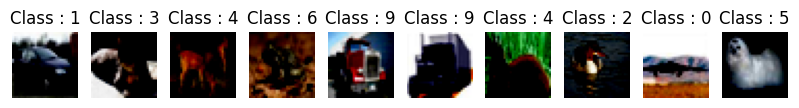

In [62]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i],(1,2,0)))
    plt.title("Class : " + str(y_train[i].item()))

In [64]:
''' 6. Multi Layer Perceptron(MLP) 모델 설계하기 '''
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [65]:
''' 7. Optimizer, Object Function 설정하기 '''
#model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f})%]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx % len(image),
                len(train_loader.dataset), 100 * batch_idx / len(train_loader),
                loss.item()
            ))

In [67]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [68]:
''' 10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}% \n'.format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0)%]	Train Loss: 2.715102
Train Epoch: 1 [8/50000 (13)%]	Train Loss: 1.537018
Train Epoch: 1 [16/50000 (26)%]	Train Loss: 1.589090
Train Epoch: 1 [24/50000 (38)%]	Train Loss: 1.295837
Train Epoch: 1 [0/50000 (51)%]	Train Loss: 1.497964
Train Epoch: 1 [8/50000 (64)%]	Train Loss: 1.477927
Train Epoch: 1 [16/50000 (77)%]	Train Loss: 1.375661
Train Epoch: 1 [24/50000 (90)%]	Train Loss: 1.407346

[EPOCH: 1], 	Test Loss: 0.0383, 	Test Accuracy: 56.58% 

Train Epoch: 2 [0/50000 (0)%]	Train Loss: 1.152402
Train Epoch: 2 [8/50000 (13)%]	Train Loss: 1.143715
Train Epoch: 2 [16/50000 (26)%]	Train Loss: 0.948962
Train Epoch: 2 [24/50000 (38)%]	Train Loss: 1.040661
Train Epoch: 2 [0/50000 (51)%]	Train Loss: 0.683536
Train Epoch: 2 [8/50000 (64)%]	Train Loss: 1.291378
Train Epoch: 2 [16/50000 (77)%]	Train Loss: 1.078713
Train Epoch: 2 [24/50000 (90)%]	Train Loss: 1.108311

[EPOCH: 2], 	Test Loss: 0.0325, 	Test Accuracy: 63.75% 

Train Epoch: 3 [0/50000 (0)%]	Train Loss: 0.70

In [69]:
''' 11. ImageNet 데이터로 학습된 ResNet34 모델을 불러온 후 Fine-tuning해보기 '''
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}% \n".format(
        Epoch, test_loss, test_accuracy
    ))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 278MB/s]


Train Epoch: 1 [0/50000 (0)%]	Train Loss: 2.264374
Train Epoch: 1 [8/50000 (13)%]	Train Loss: 1.083268
Train Epoch: 1 [16/50000 (26)%]	Train Loss: 0.853650
Train Epoch: 1 [24/50000 (38)%]	Train Loss: 1.261405
Train Epoch: 1 [0/50000 (51)%]	Train Loss: 1.264597
Train Epoch: 1 [8/50000 (64)%]	Train Loss: 0.956825
Train Epoch: 1 [16/50000 (77)%]	Train Loss: 1.016308
Train Epoch: 1 [24/50000 (90)%]	Train Loss: 0.968911

[EPOCH: 1], 	Test Loss: 0.0253, 	Test Accuracy: 72.04% 

Train Epoch: 2 [0/50000 (0)%]	Train Loss: 0.745625
Train Epoch: 2 [8/50000 (13)%]	Train Loss: 1.072258
Train Epoch: 2 [16/50000 (26)%]	Train Loss: 0.729273
Train Epoch: 2 [24/50000 (38)%]	Train Loss: 0.864542
Train Epoch: 2 [0/50000 (51)%]	Train Loss: 1.144496
Train Epoch: 2 [8/50000 (64)%]	Train Loss: 0.721966
Train Epoch: 2 [16/50000 (77)%]	Train Loss: 0.832731
Train Epoch: 2 [24/50000 (90)%]	Train Loss: 0.887411

[EPOCH: 2], 	Test Loss: 0.0234, 	Test Accuracy: 74.91% 

Train Epoch: 3 [0/50000 (0)%]	Train Loss: 0.60